In [43]:
import numpy as np
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")

In [44]:
## Adeesh data from the perspecive paper
df_val = pd.read_csv("gemnet-relaxations.csv", index_col=0)
df_val["error"] = np.abs(df_val["energy dE [eV]"] - df_val["genmet_T_predE"])
# sort error column in descending order
df_val.sort_values(by=['error'], inplace=True, ascending=False)

In [45]:
## pick the 100 nonmetallic systems with the highest ML errors
df_nonmetals = df_val.query("material_type == 'nonmetals'")
sids = df_nonmetals.iloc[:101]["ID"].values

In [75]:
## load the mappings stored from previous experiments
with open('dft_settings_study_mappings.pickle', 'rb') as read_file:
    updated_mappings = pickle.load(read_file)
df_full = pd.DataFrame(updated_mappings).transpose()
# make a dataframe from the mappings and query for the system of choice
df_full.rename(columns={'class': 'cat_class'}, inplace=True)

In [77]:
def unconverged_scf(df):
    uuids = df.index.values
    results = {}
    for uuid in tqdm(uuids):
        max_nelm = df.loc[uuid]["max_nelm"]
        nelm = df.loc[uuid]["nelm"]
        last_scf_cycle_dE = df.loc[uuid]["last_scf_cycle_dE"]
        if (np.abs(last_scf_cycle_dE)>0.0001) & (nelm==max_nelm):
            results[uuid] = last_scf_cycle_dE
    return results

## ENCUT convergence

In [78]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only encut calcualtions
df = df.query("sigma==0.2&k_point_multiplier==40")

In [79]:
# check for scf convergence
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 1018/1018 [00:00<00:00, 4965.86it/s]


In [80]:
def energy_encut_conv(df,encut_values, material):
    all_final_energies = {}
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for encut in encut_values: 
                final_energies.append(df_sid.query(f"encut=={encut}")['final_energy'].values[0])
            all_final_energies[sid] = final_energies
            plt.plot(encut_values, np.array(final_energies) - final_energies[-1], "-o",)
        except IndexError as exception:
            pass
#             print(f"{sid} has some unfinshed calculations")
    plt.title(f"{material} energy convergence vs encut")       
    plt.xlabel("encut (ev)")
    plt.ylabel("Energy convergence error (ev)");
    return all_final_energies

100%|██████████| 81/81 [00:00<00:00, 91.50it/s]


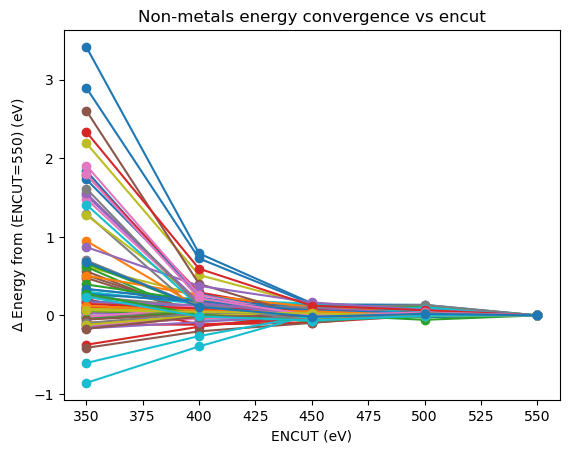

In [81]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_encut = energy_encut_conv(worst_nonmetals_df_adslab,
                                          encut_values=[350,400,450,500,550],material="Non-metals")
plt.xlabel("ENCUT (eV)")
plt.ylabel("$\Delta$ Energy from (ENCUT=550) (eV)");

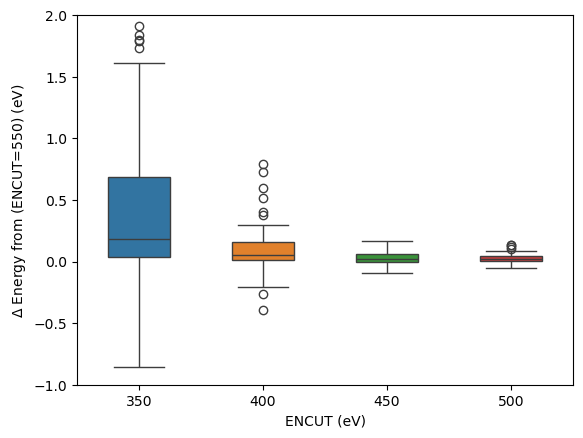

In [82]:
new_fig = np.array(list(nonmetals_energy_encut.values()))-np.array(list(nonmetals_energy_encut.values()))[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"350":new_fig[:,0],
                          "400":new_fig[:,1],
                          "450":new_fig[:,2],
                          "500":new_fig[:,3],})
sns.boxplot(data = new_fig_df ,widths=0.5)
plt.xlabel("ENCUT (eV)")
plt.ylabel(r"$\Delta$ Energy from (ENCUT=550) (eV)")
plt.ylim((-1,2));

## KPOINTS Convergence

In [83]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only encut calcualtions
df = df.query("sigma==0.2&encut==350")

In [84]:
# check for scf convergence
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 608/608 [00:00<00:00, 6427.39it/s]


In [85]:
def kpt_convergence(df,kpts_values, material):
    all_final_energies = []
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for kpt in kpts_values: 
                final_energies.append(df_sid.query(f"k_point_multiplier=={kpt}")['final_energy'].values[0])
            all_final_energies.append(final_energies)
            plt.plot(kpts_values, 
                     np.array(final_energies) - final_energies[-1], "-o",)
        except IndexError as exception:
            pass
#             print(f"{sid} has some unfinshed calculations")
    plt.title(f"{material} convergence vs k-points")       
    plt.xlabel("K-point multiplier")
    plt.ylabel("Energy convergence error (ev)");
    return np.array(all_final_energies) 

100%|██████████| 84/84 [00:00<00:00, 163.39it/s]


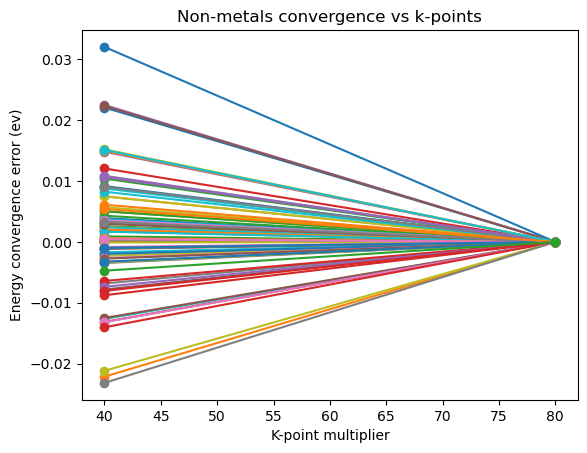

In [86]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
kpts_df = worst_nonmetals_df_adslab.query("cat_class==2&ads_symbols.isnull()==False&oc20_sid.isnull()==False")
nonmetals_kpt = kpt_convergence(kpts_df,kpts_values=[40,80],material="Non-metals")

## SIGMA Convergence

In [87]:
# remove unfinished calculations
df = df_full.query("final_energy.isnull()==False")
# get only sigma calcualtions
df = df.query("encut==350&k_point_multiplier==40")

In [88]:
results = unconverged_scf(df)
# get the sid for the systems that even have a single calc not converged to remove from the analysis
unconv = list(df.loc[list(results.keys())].oc20_sid.values)
# remove the unconverged systems
df = df.query(f"oc20_sid != {unconv}")

100%|██████████| 2117/2117 [00:00<00:00, 6560.35it/s]


In [89]:
def sigma_Econv(df, sigma_values, material):
    all_final_energies = []
    for sid in tqdm(np.unique(df.oc20_sid)):
        try: 
            df_sid = df.query(f"oc20_sid == '{sid}'") 
            final_energies = [] 
            for sig in sigma_values : 
                final_energies.append(df_sid.query(f"sigma=={sig}")['final_energy'].values[0])
            all_final_energies.append(final_energies)
            plt.plot(sigma_values, 
                     np.array(final_energies) - final_energies[-1], "-o",) 
        except IndexError as exception:
            pass
    plt.title(f"{material} convergence vs sigma")       
    plt.xlabel("sigma")
    plt.ylabel("Energy convergence error (ev)");
    return np.array(all_final_energies)

100%|██████████| 65/65 [00:00<00:00, 98.49it/s] 


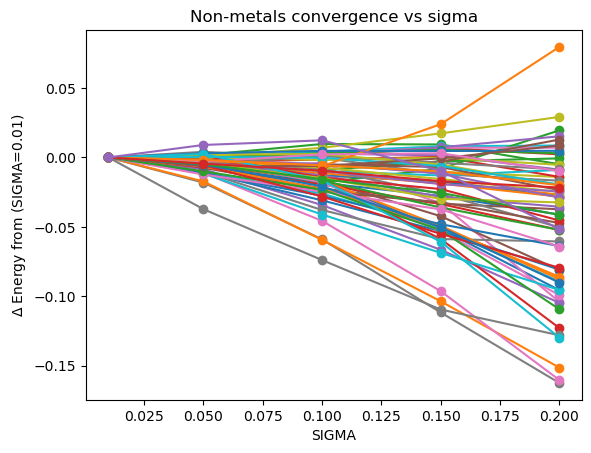

In [90]:
worst_nonmetals_df_adslab= df.query(f"oc20_sid=={list(sids)}")
nonmetals_energy_sigma = sigma_Econv(worst_nonmetals_df_adslab,sigma_values=[0.2,0.15,0.1,0.05,0.01]
                                  ,material="Non-metals")
plt.xlabel("SIGMA")
plt.ylabel(r"$\Delta$ Energy from (SIGMA=0.01)");

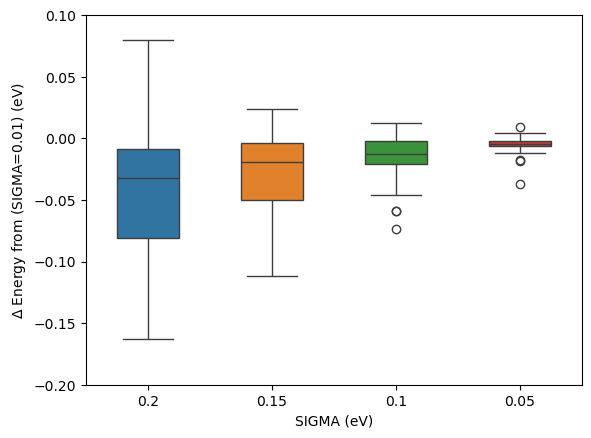

In [91]:
new_fig = nonmetals_energy_sigma-nonmetals_energy_sigma[:,-1].reshape(-1,1)
new_fig_df = pd.DataFrame({"0.2":new_fig[:,0],
                          "0.15":new_fig[:,1],
                          "0.1":new_fig[:,2],
                          "0.05":new_fig[:,3],
                          })
ax = sns.boxplot(data = new_fig_df ,widths=0.5)
ax.set_ylim((-0.2,0.1))
plt.xlabel("SIGMA (eV)")
plt.ylabel("$\Delta$ Energy from (SIGMA=0.01) (eV)");